In [2]:
import torch

from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat

In [3]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

In [4]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [5]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [6]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

In [8]:
class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out

In [9]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

In [10]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


In [11]:
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)

In [12]:
class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=8,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)



    def forward(self, img):
        x = self.stage1(img)
        x1 = self.stage2(x)
        x2 = self.stage3(x1)
        x3 = self.stage4(x2)
        return x,x1, x2, x3

In [13]:
# Initialize Model
encoder = SwinTransformer(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24))

# Generate Dummy Image
img1 = torch.randn(1, 3, 1024, 1024)  # Batch size 1, 3 channels, 224x224 image
img2 = torch.randn(1, 3, 1024, 1024)  # Batch size 1, 3 channels, 224x224 image

# Forward Pass
f_pre = encoder(img1)
f_post = encoder(img2)

# Check Output Shape
print(f_post[0].shape)
print(f_pre[1].shape)
print(f_pre[2].shape)
print(f_pre[3].shape)
print(f_post[0].shape)
print(f_post[1].shape)
print(f_post[2].shape)
print(f_post[3].shape)


torch.Size([1, 96, 256, 256])
torch.Size([1, 192, 128, 128])
torch.Size([1, 384, 64, 64])
torch.Size([1, 768, 32, 32])
torch.Size([1, 96, 256, 256])
torch.Size([1, 192, 128, 128])
torch.Size([1, 384, 64, 64])
torch.Size([1, 768, 32, 32])


#Difference Module

In [14]:

import torch
import torch.nn as nn
import torch.nn.functional as F


In [15]:
class MLPBlock(nn.Module):
    """ MLP block for feature transformation """
    def __init__(self, in_dim, out_dim):
        super(MLPBlock, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_dim)  # Change to BatchNorm2d

    def forward(self, x):
        """
        Input shape: (B, C, H, W)
        Apply MLP along the channel dimension.
        """
        x = self.fc(x.permute(0, 2, 3, 1))  # Change from (B, C, H, W) → (B, H, W, C)
        x = self.relu(x)
        x = x.permute(0, 3, 1, 2)  # Change back to (B, C, H, W)
        x = self.bn(x)  # Normalize along channel dimension
        return x


In [16]:
class UpsampleConvLayer(nn.Module):
    """
    Upsamples an input feature map using bilinear interpolation, then applies a convolution.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, scale_factor=2, mode="bilinear"):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Kernel size for convolution (default=3).
            scale_factor (int): Factor to upsample spatial resolution (default=2).
            mode (str): Upsampling mode ("bilinear" or "nearest").
        """
        super(UpsampleConvLayer, self).__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode=mode, align_corners=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)  # Optional normalization
        self.relu = nn.ReLU(inplace=True)  # Activation

    def forward(self, x):
        x = self.upsample(x)  # Step 1: Upsampling
        x = self.conv(x)  # Step 2: Convolution
        x = self.bn(x)  # Step 3: Normalization
        x = self.relu(x)  # Step 4: Activation
        return x

class MultiStageUpsampler(nn.Module):
    """
    Upsamples from (1, embed_dim, 7, 7) to (1, embed_dim, 56, 56)
    """

    def __init__(self, embed_dim):
        super(MultiStageUpsampler, self).__init__()

        self.up1 = UpsampleConvLayer(embed_dim, embed_dim, scale_factor=2)  # 7x7 → 14x14
        self.up2 = UpsampleConvLayer(embed_dim, embed_dim, scale_factor=2)  # 14x14 → 28x28
        self.up3 = UpsampleConvLayer(embed_dim, embed_dim, scale_factor=2)

    def forward(self, x):
        x = self.up1(x)  # 7x7 → 14x14
        x = self.up2(x)  # 14x14 → 28x28
        x = self.up3(x)  # 28x28 → 56x56
        return x

class MultiStageUpsampler2(nn.Module):
    """
    Upsamples from (1, embed_dim, 14, 14) to (1, embed_dim, 56, 56)
    """

    def __init__(self, embed_dim):
        super(MultiStageUpsampler2, self).__init__()

        self.up1 = UpsampleConvLayer(embed_dim, embed_dim, scale_factor=2)  # 14x14 → 28x28
        self.up2 = UpsampleConvLayer(embed_dim, embed_dim, scale_factor=2)   # 28x28 → 56x56


    def forward(self, x):
        x = self.up1(x)   # 14x14 → 28x28
        x = self.up2(x)  # 28x28 → 56x56

        return x

class MultiStageUpsampler3(nn.Module):
    """
    Upsamples from (1, embed_dim, 28, 28) to (1, embed_dim, 56, 56)
    """

    def __init__(self, embed_dim):
        super(MultiStageUpsampler3, self).__init__()

        self.up1 = UpsampleConvLayer(embed_dim, embed_dim, scale_factor=2)   # 28x28 → 56x56


    def forward(self, x):
        x = self.up1(x)  # 28x28 → 56x56

        return x

In [17]:
class DifferenceModule(nn.Module):
    """ Computes difference between pre-change and post-change features """
    def __init__(self, in_channels, out_channels):
        super(DifferenceModule, self).__init__()
        self.conv = nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, f_pre, f_post):
        x = torch.cat([f_pre, f_post], dim=1)  # Concatenate along the channel dimension
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

In [18]:
class ChangeDetectionDecoder(nn.Module):
    """ Complete Change Detection Decoder """
    def __init__(self, encoder_features, embed_dim):
        """
        Args:
            encoder_features: List of channel sizes from encoder
            embed_dim: Final embedding dimension
        """
        super(ChangeDetectionDecoder, self).__init__()


        # Difference Modules
        self.diff1 = DifferenceModule(encoder_features[0], encoder_features[0])
        self.diff2 = DifferenceModule(encoder_features[1], encoder_features[1])
        self.diff3 = DifferenceModule(encoder_features[2], encoder_features[2])
        self.diff4 = DifferenceModule(encoder_features[3], encoder_features[3])

        # MLP Blocks
        self.mlp1 = MLPBlock(encoder_features[0], embed_dim)
        self.mlp2 = MLPBlock(encoder_features[1], embed_dim)
        self.mlp3 = MLPBlock(encoder_features[2], embed_dim)
        self.mlp4 = MLPBlock(encoder_features[3], embed_dim)

        # Upsampling Blocks (Ensure each stage reaches H/4 x W/4)
        self.upsampler = MultiStageUpsampler(embed_dim)   # H/32 → H/4

        self.upsampler2 = MultiStageUpsampler2(embed_dim)  # H/16 → H/4
        self.upsampler3 = MultiStageUpsampler3(embed_dim)  # H/8 → H/4
        #   Already H/4

        # Feature Fusion: MLP after concatenation
        #self.concatenated = torch.cat(I1,I2,I3,I4, dim=1)
        self.fusion_mlp = MLPBlock(4*embed_dim, embed_dim)

        # Final Upsampling (H/4 → H)
        self.final_upsample = MultiStageUpsampler2(embed_dim)


        # Final Classifier (Output 2 channels: Change / No Change)
        self.classifier = nn.Conv2d(embed_dim, 2, kernel_size=1)

    def forward(self, f_pre, f_post):
        """
        Args:
            f_pre: List of multi-scale features from pre-change image
            f_post: List of multi-scale features from post-change image
        """
        # Compute feature differences
        diff1 = self.diff1(f_pre[0], f_post[0])  # (B, C, H/4, W/4)
        diff2 = self.diff2(f_pre[1], f_post[1])  # (B, C, H/8, W/8)
        diff3 = self.diff3(f_pre[2], f_post[2])  # (B, C, H/16, W/16)
        diff4 = self.diff4(f_pre[3], f_post[3])  # (B, C, H/32, W/32)

        # MLP transformation
        diff1 = self.mlp1(diff1)
        diff2 = self.mlp2(diff2)
        diff3 = self.mlp3(diff3)
        diff4 = self.mlp4(diff4)

        # Upsample all to H/4 x W/4
        up4= self.upsampler(diff4)  # H/32 → H/4
        up3 = self.upsampler2(diff3)   # H/16 → H/4
        up2 = self.upsampler3(diff2)   # H/8 → H/4
        up1=diff1  # Already at H/4


        # Concatenate all upsampled features
        fused_features = torch.cat([up1, up2, up3, up4], dim=1)  # (B, 4*C, H/4, W/4)

        # MLP for Feature Fusion
        fused_features = self.fusion_mlp(fused_features)  # (B, C, H/4, W/4)

        # Final Upsampling to H x W
        final_features = self.final_upsample(fused_features)

        # Classification
        change_map = self.classifier(final_features)  # (B, 2, H, W)

        return change_map


In [19]:
# Example usage
encoder_features = [96, 192, 384, 768]  # Swin Transformer outputs
embed_dim = 56
out_channels=56  # Intermediate feature dimension

decoder = ChangeDetectionDecoder(encoder_features, embed_dim)

# Run forward pass
change_map = decoder(f_pre, f_post)

print(change_map.shape)  # Expected output: (1, 2, 224, 224)


torch.Size([1, 2, 1024, 1024])


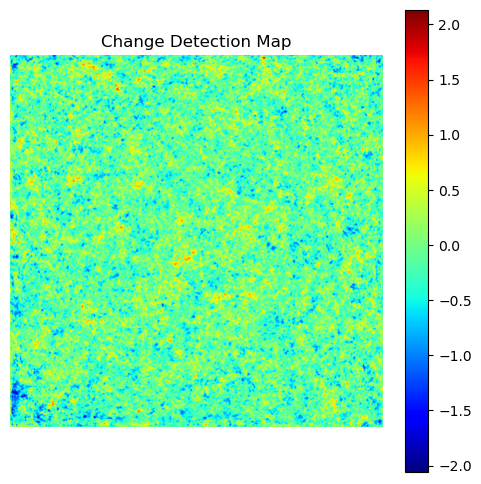

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Function to visualize the output
def plot_change_map(change_map):
    """
    Plots the output change detection map.

    Args:
        change_map (torch.Tensor): Output from the decoder with shape (B, 2, H, W)
    """
    change_map = change_map.detach().cpu().numpy()[0]  # Convert to numpy and take the first batch
    change_map = change_map[1]  # Take the second channel (change probability)

    plt.figure(figsize=(6, 6))
    plt.imshow(change_map, cmap='jet')
    plt.colorbar()
    plt.title("Change Detection Map")
    plt.axis("off")
    plt.show()

# Generate output from the decoder
change_map = decoder(f_pre, f_post)

# Plot the result
plot_change_map(change_map)


# Data Reading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os

# Define dataset root path
dataset_root = "/home/aniketj/mtp2/Dataset"

# Define paths to training folders
train_A_path = os.path.join(dataset_root, "train", "A")      # Post-change images
train_B_path = os.path.join(dataset_root, "train", "B")      # Pre-change images
train_label_path = os.path.join(dataset_root, "train", "label")  # Ground truth masks

# Check if paths exist
assert os.path.exists(train_A_path), "Train A path not found!"
assert os.path.exists(train_B_path), "Train B path not found!"
assert os.path.exists(train_label_path), "Label path not found!"

print("Dataset structure verified! ✅")


Dataset structure verified! ✅


In [22]:
# List first 5 images in each folder
print("Train A (Post-change) samples:", sorted(os.listdir(train_A_path))[:5])
print("Train B (Pre-change) samples:", sorted(os.listdir(train_B_path))[:5])
print("Train Labels (Ground Truth) samples:", sorted(os.listdir(train_label_path))[:5])


Train A (Post-change) samples: ['train_1.png', 'train_10.png', 'train_100.png', 'train_101.png', 'train_102.png']
Train B (Pre-change) samples: ['train_1.png', 'train_10.png', 'train_100.png', 'train_101.png', 'train_102.png']
Train Labels (Ground Truth) samples: ['train_1.png', 'train_10.png', 'train_100.png', 'train_101.png', 'train_102.png']


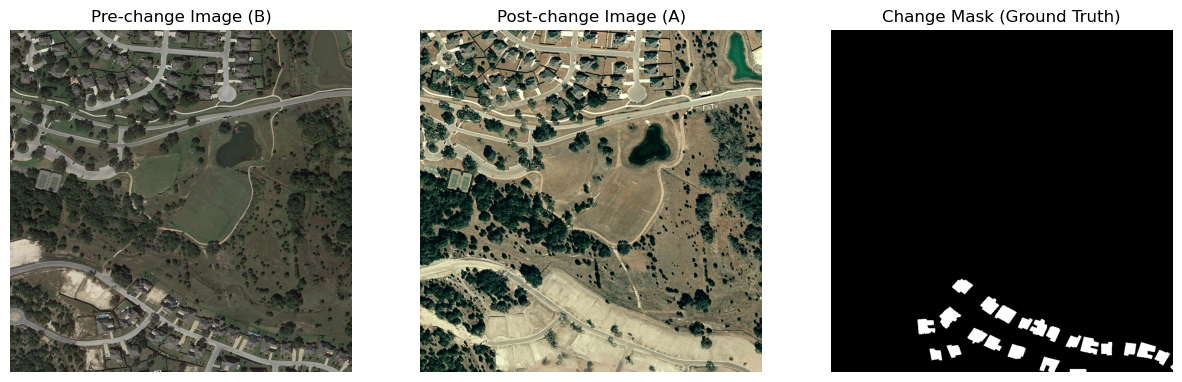

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

# Select a sample image
sample_name = sorted(os.listdir(train_A_path))[0]  # Pick first image

# Construct file paths
pre_change_path = os.path.join(train_B_path, sample_name)
post_change_path = os.path.join(train_A_path, sample_name)
label_path = os.path.join(train_label_path, sample_name)

# Load images
pre_change = Image.open(pre_change_path).convert("RGB")  # Convert to RGB
post_change = Image.open(post_change_path).convert("RGB")
label = Image.open(label_path).convert("L")  # Convert to grayscale (binary mask)

# Display images side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(pre_change)
ax[0].set_title("Pre-change Image (B)")
ax[0].axis("off")

ax[1].imshow(post_change)
ax[1].set_title("Post-change Image (A)")
ax[1].axis("off")

ax[2].imshow(label, cmap="gray")
ax[2].set_title("Change Mask (Ground Truth)")
ax[2].axis("off")

plt.show()


In [24]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to tensor
])

def split_image_into_patches(image, patch_size=256, stride=256):
    """
    Splits a 1024x1024 image into 16 individual patches of 256x256.

    Args:
        image (PIL Image or torch.Tensor): Input image
        patch_size (int): Size of each patch (default: 256)
        stride (int): Stride for patch extraction (default: 256)

    Returns:
        List of patches [(C, 256, 256), ...]
    """
    if isinstance(image, Image.Image):
        image = transform(image)  # Convert to tensor

    C, H, W = image.shape  # Expected: (3, 1024, 1024)
    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = image[:, i:i+patch_size, j:j+patch_size]  # Shape: (C, 256, 256)
            patches.append(patch)

    return patches  # List of 16 patches

import torch

class LEVIRPatchDataset(Dataset):
    """ Dataset for LEVIR-CD with 256x256 patches (without dataset size increase) """

    def __init__(self, root_dir, split="train", use_fraction=1/16):
        """
        Args:
            root_dir (str): Root directory of LEVIR-CD dataset.
            split (str): "train", "val", or "test".
            use_fraction (float): Fraction of dataset to use (default 1/16).
        """
        self.root_dir = root_dir
        self.split = split

        # Paths to images
        self.img_dir_A = os.path.join(root_dir, split, "A")
        self.img_dir_B = os.path.join(root_dir, split, "B")
        self.label_dir = os.path.join(root_dir, split, "label")

        # Get sorted filenames
        all_files = sorted([f for f in os.listdir(self.img_dir_A) if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Use only the first 1/16th images
        total_images = len(all_files)
        selected_images = int(total_images * use_fraction)
        self.image_filenames = all_files[:selected_images]  # Keep only a subset

        # Create a list of individual patches (flatten all patches)
        self.patches = self._generate_patch_list()

    def _generate_patch_list(self):
        """ Generate list of individual patches from selected images """
        patch_list = []

        for img_name in self.image_filenames:
            img_A = Image.open(os.path.join(self.img_dir_A, img_name)).convert("RGB")
            img_B = Image.open(os.path.join(self.img_dir_B, img_name)).convert("RGB")
            label = Image.open(os.path.join(self.label_dir, img_name)).convert("L")

            # Convert and split into patches
            img_A_patches = split_image_into_patches(img_A)  # List of 16 patches
            img_B_patches = split_image_into_patches(img_B)  # List of 16 patches
            label_patches = split_image_into_patches(label)  # List of 16 patches

            # Store each patch as an independent dataset entry
            for i in range(16):  # Each image generates 16 patches
                patch_list.append((img_A_patches[i], img_B_patches[i], label_patches[i]))

        return patch_list  # Now dataset size = original images count

    def __len__(self):
        """Returns total number of patches (equal to original image count)."""
        return len(self.patches)

    def __getitem__(self, idx):
        """Returns an individual patch (C, 256, 256)."""
        img_A_patch, img_B_patch, label_patch = self.patches[idx]

        return img_A_patch, img_B_patch, label_patch  # Now, each patch is independent



In [25]:
import os
from torch.utils.data import DataLoader

# Define dataset root
dataset_root = "/home/aniketj/mtp2/Dataset"

# Define dataset splits
splits = ["train", "val", "test"]

# Define dataset paths dynamically
dataset_paths = {
    split: {
        "A": os.path.join(dataset_root, split, "A"),        # Post-change images
        "B": os.path.join(dataset_root, split, "B"),        # Pre-change images
        "label": os.path.join(dataset_root, split, "label") # Ground truth masks
    }
    for split in splits
}

# Ensure all paths exist
for split, paths in dataset_paths.items():
    assert os.path.exists(paths["A"]), f"Error: {split} A folder not found!"
    assert os.path.exists(paths["B"]), f"Error: {split} B folder not found!"
    assert os.path.exists(paths["label"]), f"Error: {split} label folder not found!"

print("✅ All dataset paths verified!")


✅ All dataset paths verified!


In [26]:
# Define batch size
batch_size = 16

# Create dataset instances
train_dataset = LEVIRPatchDataset(root_dir=dataset_root, split="train", use_fraction=1/16)
val_dataset = LEVIRPatchDataset(root_dir=dataset_root, split="val", use_fraction=1/16)
test_dataset = LEVIRPatchDataset(root_dir=dataset_root, split="test", use_fraction=1/16)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✅ Train, Validation, and Test DataLoaders created successfully!")


✅ Train, Validation, and Test DataLoaders created successfully!


#Model Creation

In [27]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [28]:
hidden_dim=96
layers=(2, 2, 6, 2)
heads=(3, 6, 12, 24)
encoder_features = [96, 192, 384, 768]
embed_dim = 56
out_channels=56

In [29]:
class SwinChangeDetectionModel(nn.Module):
    def __init__(self, hidden_dim, layers, heads, embed_dim):
        super(SwinChangeDetectionModel, self).__init__()

        # Swin Transformer Encoder
        self.encoder = SwinTransformer(
            hidden_dim=hidden_dim, layers=layers, heads=heads)

        # Change Detection Decoder
        self.decoder = ChangeDetectionDecoder(encoder_features, embed_dim)

    def forward(self, img1, img2):
        # Pass both images through the Swin Transformer encoder
        encoded_features1 = self.encoder(img1)
        encoded_features2 = self.encoder(img2)

        # Pass encoded features to the decoder
        change_map = self.decoder(encoded_features1, encoded_features2)

        return change_map


In [30]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():  # No gradient calculation
        for img_A_patch, img_B_patch, label_patch in test_loader:
            img_A_patch, img_B_patch, label_patch = (
                img_A_patch.to(device), img_B_patch.to(device), label_patch.to(device)
            )

            # Convert label (B, 1, H, W) → (B, H, W)
            label_patch = label_patch.squeeze(1)  # Remove single channel to match predictions

            # Forward pass
            outputs = model(img_A_patch, img_B_patch)  # (B, 2, H, W)

            # Convert logits to binary predictions
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            # Flatten tensors before appending to the list
            all_preds.append(preds.cpu().numpy().flatten())
            all_labels.append(label_patch.cpu().numpy().flatten())

    # Convert lists to numpy arrays (avoid slow tensor creation)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Compute final metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"🔥 Model Evaluation - Acc: {accuracy:.4f} | Prec: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")


In [31]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device='cuda'):
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Store metrics for plotting
    epoch_losses = []
    epoch_accuracies = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for img_A_patch, img_B_patch, label_patch in train_loader:
            img_A_patch, img_B_patch, label_patch = (
                img_A_patch.to(device), img_B_patch.to(device), label_patch.to(device)
            )

            # Convert label (B, 1, H, W) → (B, 2, H, W)
            label_patch = torch.cat([1 - label_patch, label_patch], dim=1)

            # Forward pass
            outputs = model(img_A_patch, img_B_patch)  # (B, 2, H, W)

            # Compute loss
            loss = criterion(outputs, label_patch)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Convert predictions to binary (0/1)
            preds = torch.argmax(outputs, dim=1)  # (B, H, W) → 0 for No Change, 1 for Change
            labels = label_patch[:, 1, :, :]      # Extract Change class from labels (B, H, W)

            # Flatten tensors to compute metrics
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

        # Compute metrics for epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        avg_loss = total_loss / len(train_loader)

        # Store metrics
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1_scores.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    # Plot metrics after training
    plot_metrics(epoch_losses, epoch_accuracies, epoch_precisions, epoch_recalls, epoch_f1_scores)


In [32]:
def plot_metrics(losses, accuracies, precisions, recalls, f1_scores):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label="Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot Metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Accuracy", color="blue")
    plt.plot(epochs, precisions, label="Precision", color="green")
    plt.plot(epochs, recalls, label="Recall", color="purple")
    plt.plot(epochs, f1_scores, label="F1 Score", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Training Metrics Over Epochs")
    plt.legend()

    plt.show()


In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0)) 

True
NVIDIA GeForce RTX 3060


Epoch [1/50] - Loss: 0.4340 | Acc: 0.8800 | Prec: 0.2290 | Recall: 0.3268 | F1: 0.2693
Epoch [2/50] - Loss: 0.2481 | Acc: 0.9426 | Prec: 0.5996 | Recall: 0.4565 | F1: 0.5184
Epoch [3/50] - Loss: 0.1818 | Acc: 0.9518 | Prec: 0.6936 | Recall: 0.5145 | F1: 0.5908
Epoch [4/50] - Loss: 0.1527 | Acc: 0.9550 | Prec: 0.7176 | Recall: 0.5512 | F1: 0.6235
Epoch [5/50] - Loss: 0.1287 | Acc: 0.9608 | Prec: 0.7681 | Recall: 0.6017 | F1: 0.6748
Epoch [6/50] - Loss: 0.1133 | Acc: 0.9642 | Prec: 0.7963 | Recall: 0.6337 | F1: 0.7058
Epoch [7/50] - Loss: 0.1071 | Acc: 0.9648 | Prec: 0.7941 | Recall: 0.6485 | F1: 0.7139
Epoch [8/50] - Loss: 0.0951 | Acc: 0.9684 | Prec: 0.8145 | Recall: 0.6905 | F1: 0.7474
Epoch [9/50] - Loss: 0.0866 | Acc: 0.9701 | Prec: 0.8185 | Recall: 0.7180 | F1: 0.7649
Epoch [10/50] - Loss: 0.0792 | Acc: 0.9730 | Prec: 0.8412 | Recall: 0.7406 | F1: 0.7877
Epoch [11/50] - Loss: 0.0715 | Acc: 0.9748 | Prec: 0.8474 | Recall: 0.7659 | F1: 0.8046
Epoch [12/50] - Loss: 0.0755 | Acc: 0.973

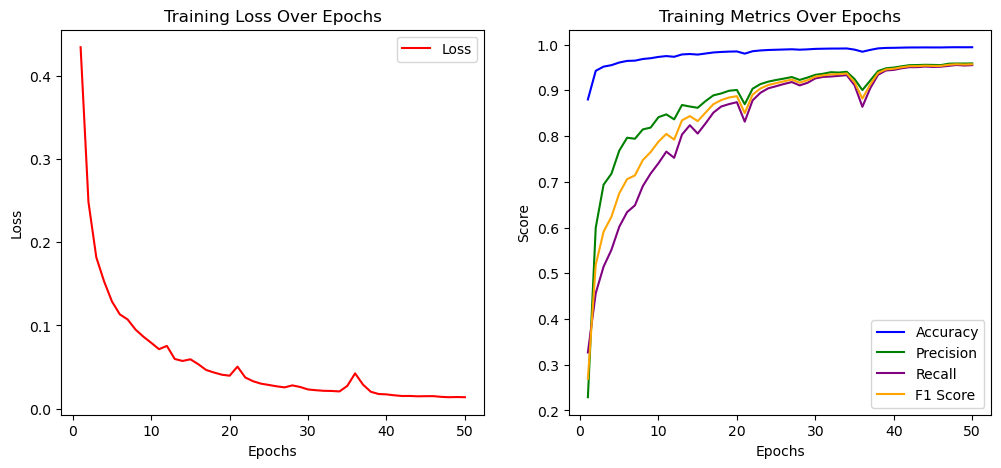

In [35]:
# Define batch size
batch_size = 2


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate Model
model = SwinChangeDetectionModel(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), embed_dim=128)

# Train the model
train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device="cuda")


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def visualize_predictions(model, test_loader, num_samples=5, device='cuda'):
    """
    Runs inference on the test dataset and visualizes predicted vs. true labels.

    Args:
        model (torch.nn.Module): Trained change detection model.
        test_loader (DataLoader): DataLoader for test dataset.
        num_samples (int): Number of images to visualize.
        device (str): Device ('cuda' or 'cpu').
    """
    model.eval()
    transform_to_pil = transforms.ToPILImage()

    all_preds, all_labels = [], []  # Store for metric calculation

    with torch.no_grad():
        count = 0
        for img_A_patch, img_B_patch, label_patch in test_loader:
            img_A_patch, img_B_patch, label_patch = (
                img_A_patch.to(device), img_B_patch.to(device), label_patch.to(device)
            )

            # Convert label (B, 1, H, W) → (B, H, W)
            label_patch = label_patch.squeeze(1)  # Remove single channel for labels

            # Forward pass
            outputs = model(img_A_patch, img_B_patch)  # (B, 2, H, W)

            # Convert logits to binary predictions
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            # Flatten tensors for metric computation
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(label_patch.cpu().numpy().flatten())

            # Convert tensors to numpy
            img_A_np = img_A_patch.cpu().numpy()
            img_B_np = img_B_patch.cpu().numpy()
            preds_np = preds.cpu().numpy()
            labels_np = label_patch.cpu().numpy()

            # Plot `num_samples` predictions
            for i in range(min(num_samples, img_A_np.shape[0])):
                plt.figure(figsize=(12, 4))

                # Convert images to PIL format properly
                img_A_pil = transform_to_pil(img_A_np[i].transpose(1, 2, 0))  # Convert (C, H, W) → (H, W, C)
                img_B_pil = transform_to_pil(img_B_np[i].transpose(1, 2, 0))

                # Plot Pre-change Image
                plt.subplot(1, 4, 1)
                plt.imshow(img_A_pil)
                plt.title("Pre-change Image")
                plt.axis("off")

                # Plot Post-change Image
                plt.subplot(1, 4, 2)
                plt.imshow(img_B_pil)
                plt.title("Post-change Image")
                plt.axis("off")

                # Plot Ground Truth Label
                plt.subplot(1, 4, 3)
                plt.imshow(labels_np[i], cmap="gray")
                plt.title("True Change Mask")
                plt.axis("off")

                # Plot Model Prediction
                plt.subplot(1, 4, 4)
                plt.imshow(preds_np[i], cmap="gray")
                plt.title("Predicted Change Mask")
                plt.axis("off")

                plt.show()

                count += 1
                if count >= num_samples:
                    break

    # Compute final metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"\n🔥 Model Evaluation Results:")
    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")


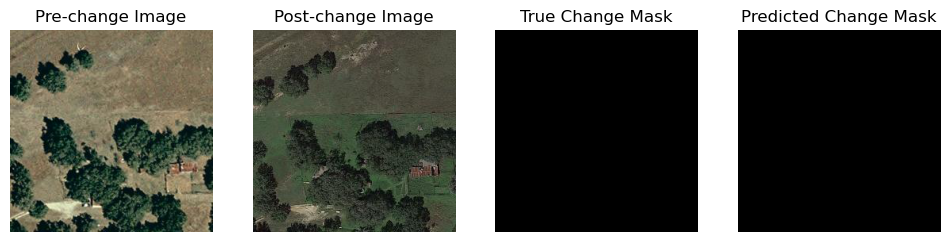

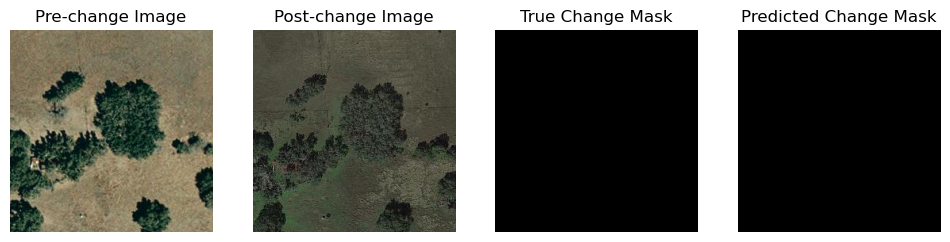

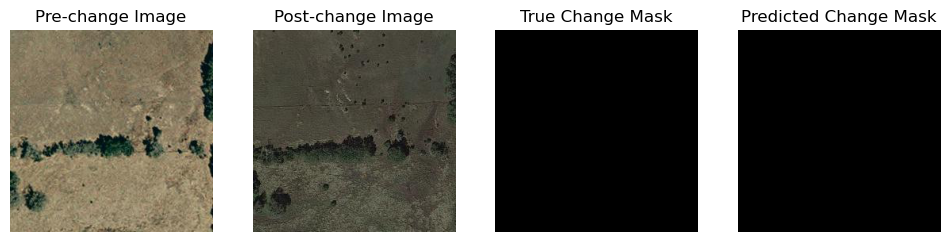

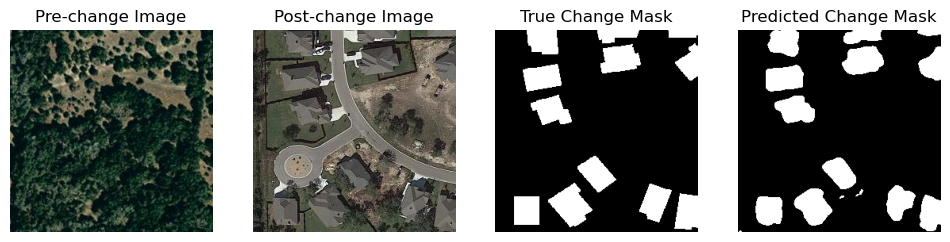

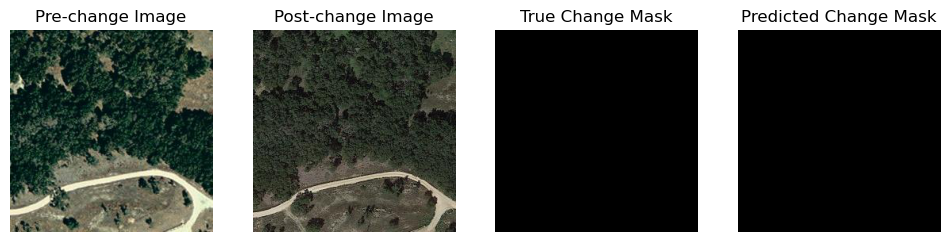

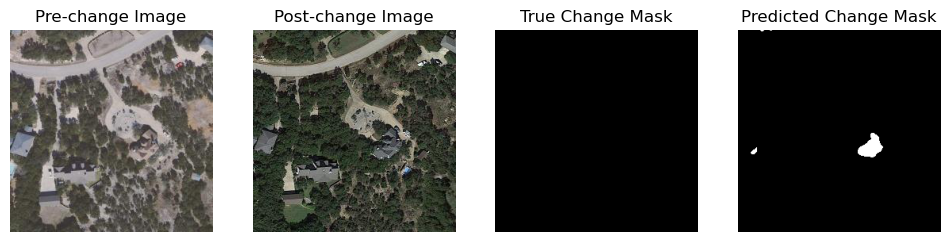

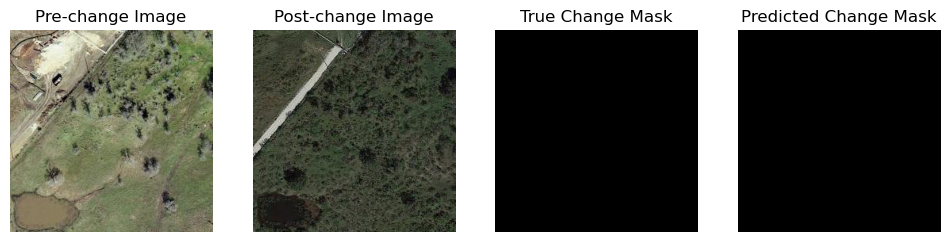

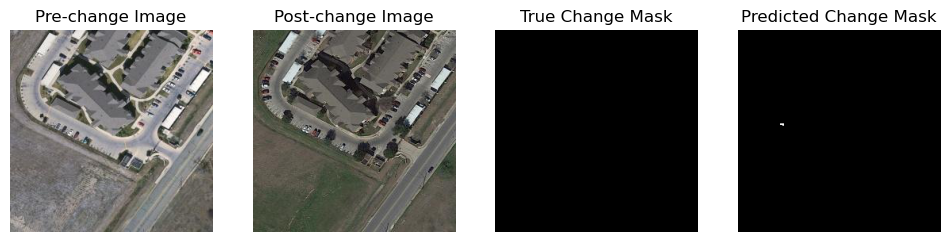

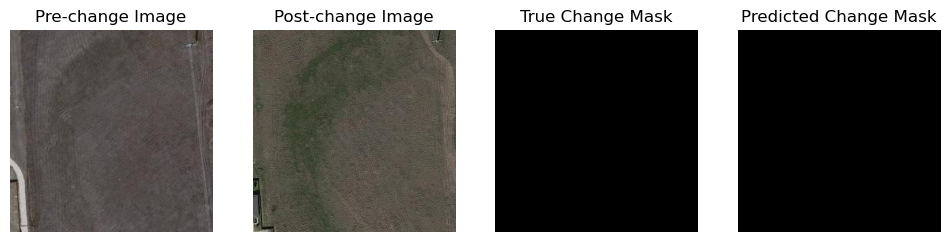

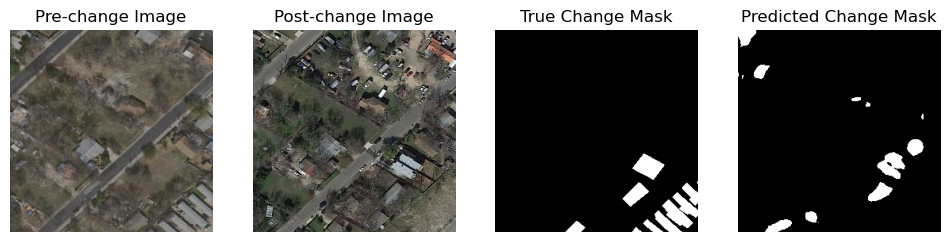

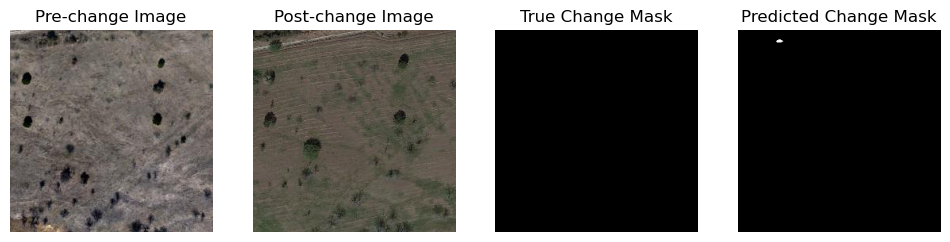

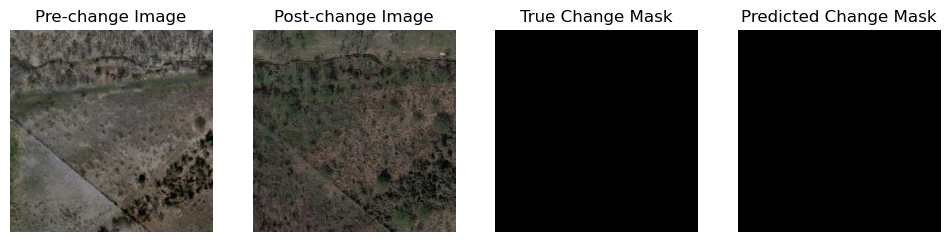


🔥 Model Evaluation Results:
✅ Accuracy:  0.9687
✅ Precision: 0.7871
✅ Recall:    0.6191
✅ F1 Score:  0.6931


In [37]:
# Evaluate on the test dataset
# Visualize the first 5 test samples
visualize_predictions(model, test_loader, num_samples=5, device='cuda')

